In [568]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import datetime as dt


%matplotlib inline

In [569]:
log_path = "/home/astepenko/logs/syslog_77"

with open(log_path, "r", encoding="utf-8") as f:
    log = f.readlines()

In [570]:
# log size
len(log)

15491900

## Log processing

In [571]:
aqt_log = []
status_log = []

is_status, arr_status, scop, err_cnt, cnt = False, [], None, 0, 0
for row in log:
    d = {'date': np.nan, 'hostname': np.nan, 'process': np.nan, 'timestamp': np.nan, 'guid': np.nan, 'module': np.nan, 'module_id': np.nan, 'method': np.nan, 'level': np.nan, 'content': np.nan}
    cnt += 1
    if cnt % 1e6 == 0:
        print(f'{cnt} of {len(log)}')
    try:
        if 'AquetiDaemonProcess' not in row:
            continue
            
        ind = row.index("]: ") + 2

        part = row[:ind-1].split(" ")
        d["date"] = f"{dt.date.today().year}-{dt.datetime.strptime(part[0], '%b').month}-{part[1]} {part[2]}"
        d["hostname"] = part[3]
        d["process"] = part[4]            

        parts = row[ind+1:].split("::")
        
        if len(parts) == 4:
            part = parts[0].split(" ")
            d["timestamp"] = int(part[0][1:-1])
            d["guid"] = part[1]

            part = parts[1]
            d["module"], d["module_id"] = part.split("(")
            d["module_id"] = d["module_id"][:-1]

            part = parts[2]
            d["method"] = part

            part = parts[3]
            ind = part.index(":")
            d["level"] = part[:ind]
            d["content"] = part[ind+1:].strip()            
        elif len(parts) == 2:
            part = parts[0]            
            d["module"], d["module_id"] = part.split("(")
            
            part = parts[1].split(":")
            d["method"] = part[0].strip()
            d["content"] = part[1].strip()            
        else:
            part = parts[0]
            
            if re.findall(r"status request on scopcontroller\. entity: \d+\s?$", part):                
                scop = part[part.rindex(":")+1:].strip()
                is_status = True
                            
            if is_status:
                if part[:4] != "#011":
                    err_cnt += 1
                if err_cnt > 6:
                    is_status, arr_status, err_cnt = False, [], 0
                                    
                arr_status.append(part.replace("#011", ""))                
             
                if arr_status[-1] == "}\n":
                    r = json.loads("".join(arr_status[arr_status.index('{\n'):]))
                    r['camera'], r['date'], r['process'] = scop, d['date'], d['process']
                    status_log.append(r) # {**d, **r}
                    is_status, arr_status, err_cnt = False, [], 0
                
                continue
                            
            d["content"] = part.strip()
        
        aqt_log.append(d)        
    except:
        #print(row)
        pass
        

1000000 of 15491900
2000000 of 15491900
3000000 of 15491900
4000000 of 15491900
5000000 of 15491900
6000000 of 15491900
7000000 of 15491900
8000000 of 15491900
9000000 of 15491900
10000000 of 15491900
11000000 of 15491900
12000000 of 15491900
13000000 of 15491900
14000000 of 15491900
15000000 of 15491900


**Converting dict's to df's**

In [572]:
df = pd.DataFrame(aqt_log)
df_status = pd.DataFrame(status_log)

**Describing dataframe**

In [573]:
df.loc[:, df.columns != 'timestamp'].describe()

,date,hostname,process,guid,module,module_id,method,level,content
count,12736276,12736276,12736276,2149766,2150255,2150255,2150255,2149766,12736276
unique,75507,1,8,8,27,1236,101,32,485813
top,2021-4-20 16:45:48,seneca,AquetiDaemonProcess[16049],e4434b1d73cc1598284548989336,DirectoryServicesServer.cpp,e4434b1d73cc1598284548989336,submoduleCreated,DEBUG,got digital cam gain: 1
freq,5623,12736276,3941551,2149741,1632582,1733901,1024974,1010710,1470259


**date**

In [574]:
df['date'] = df['date'].astype('datetime64')

**hostname**

In [575]:
# contains just one unique value, dropping

df = df.drop(['hostname'], axis=1)

**process**

In [576]:
df['process'].value_counts(dropna=False)

AquetiDaemonProcess[16049]    3941551
AquetiDaemonProcess[19238]    2922004
AquetiDaemonProcess[14922]    2244733
AquetiDaemonProcess[24078]    2054438
AquetiDaemonProcess[9391]     1488657
AquetiDaemonProcess[24073]      55659
AquetiDaemonProcess[7715]       16535
AquetiDaemonProcess[3661]       12699
Name: process, dtype: int64

**guid**

In [577]:
# contains just one unique value, dropping

df = df.drop(['guid'], axis=1)

**module**

In [578]:
modules = df["module"].value_counts()[:12].index.to_list()
modules

['DirectoryServicesServer.cpp',
 'ClientSubmodule.cpp',
 'AquetiDaemonServer.cpp',
 'MnemosyneServer.cpp',
 'RenderStream.cpp',
 'CronusServer.cpp',
 'HyperionServer.cpp',
 'DataRequestRouter.cpp',
 '  ',
 'ServerSubmodule.cpp',
 'operator',
 'ModelHandlerServer.cpp']

In [579]:
df = df[df['module'].isin(modules)]

**module_id**

In [580]:
# leaving as is

**method**

In [581]:
methods = df["method"].value_counts()[:60].index.to_list()
methods[:5]

['submoduleCreated',
 'operator()',
 'connectToNewDaemons',
 'handleNewlyDiscoveredDaemons',
 'getSubmodule']

In [582]:
df = df[df['method'].isin(methods)]

**level**

In [583]:
levels = df['level'].value_counts()[:4].index.to_list()
levels

['DEBUG', 'WARNING', 'ERROR', 'CRITICAL']

In [584]:
df = df[df['level'].isin(levels)]

**content**

In [164]:
# leaving as is

----------------------------------------

In [585]:
num_cols = df_status.select_dtypes(exclude="object").columns.to_list()
cat_cols = df_status.select_dtypes(include="object").columns.to_list()

**Describing status dataframe**

In [586]:
df_status[cat_cols].describe()

,auto_analog_gain_enabled,auto_digital_gain_enabled,auto_exposure_enabled,auto_ir_filter_enabled,auto_model_generation_enabled,auto_night_mode_enabled,auto_whitebalance,autofocus_algorithm,compression_quality_modes,data_routing_policy,...,software,state,supported_autofocus_algorithms,supported_framerates,supported_whitebalance_modes,system_auto_enabled,whitebalance_mode,camera,date,process
count,14957,14957,14957,14957,14957,14957,14957,14957,14957,14957,...,14957,14957,14957,14957,14957,14957,14957,14973,14973,14973
unique,2,1,1,1,1,2,2,1,1,1,...,1,2,1,1,1,2,4,5,3457,7
top,False,False,False,True,True,False,True,standard,"[high, medium, low]",,...,3.1.0.0-Ubuntu18.04_develop,"{'All Mcams Connected': 'WARNING', 'Database C...","[standard, expert]","[5, 10, 15, 20, 25, 30]","[AUTO, CLOUDY, FIXED, FLUORESCENT, HORIZON, IN...",True,AUTO,2,2021-4-20 16:58:27,AquetiDaemonProcess[16049]
freq,11994,14957,14957,14957,14957,8951,14797,14957,14957,14957,...,14957,10717,14957,14957,14957,11994,8206,3016,35,6179


## Investigation

### General info

**Log period**

In [587]:
f"{df['date'].min()} - {df['date'].max()}"

'2021-04-20 00:08:47 - 2021-04-20 21:10:27'

**Number of messages per log level**

<AxesSubplot:title={'center':'Number of messages per log level'}, xlabel='level'>

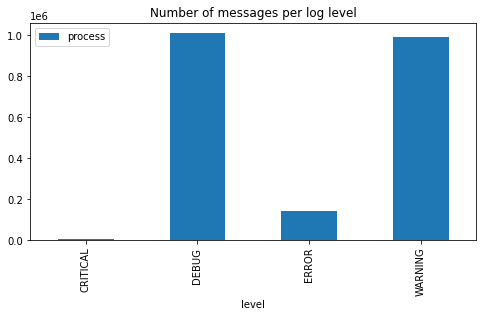

In [588]:
df[['process', 'level']].groupby(['level']).count().reset_index().plot.bar('level', 'process', figsize=(8,4), title='Number of messages per log level')

**Most common spam lines**

In [589]:
df['content'].value_counts().reset_index().loc[0]

index      Failed to emplace submodule connection informa...
content                                               510362
Name: 0, dtype: object

In [590]:
from collections import Counter

tmp = df[['level', 'content']].groupby(['level']).agg(Counter).reset_index()
tmp['total_lines'] = tmp['content'].apply(lambda d: np.sum(d.values())).apply(sum)
tmp['line_rate'] = tmp['content'].apply(lambda d: max(d.values()))
tmp['line'] = tmp['content'].apply(lambda d: max(d, key=d.get))
tmp = tmp.drop(['content'], axis=1)
tmp

,level,total_lines,line_rate,line
0,CRITICAL,6018,6004,"NTP offset is zero, this generally means we ha..."
1,DEBUG,1010655,49454,Satisfied request for submodule {
2,ERROR,142996,557,Failed to tell AquetiDaemonServer_042251703688...
3,WARNING,989926,510362,Failed to emplace submodule connection informa...


**Most common spam words**

In [591]:
words = ['ping', 'emplace', 'submodule']
for word in words:
    print(f"{word}: {df['content'].str.contains(word).sum()}")

ping: 612365
emplace: 510375
submodule: 1087563


In [592]:
text = " ".join(list(df['content'].values))

(-0.5, 399.5, 199.5, -0.5)

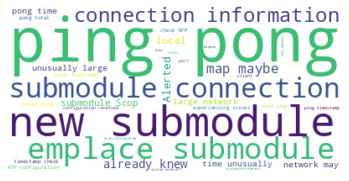

In [593]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
wordcloud = WordCloud(max_font_size=75, max_words=100, background_color="white").generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")

### Server daemon

**Number of Aqueti-Daemon instances**

In [594]:
df['process'].unique().tolist()

['AquetiDaemonProcess[24078]',
 'AquetiDaemonProcess[9391]',
 'AquetiDaemonProcess[16049]',
 'AquetiDaemonProcess[19238]',
 'AquetiDaemonProcess[24073]',
 'AquetiDaemonProcess[3661]',
 'AquetiDaemonProcess[7715]',
 'AquetiDaemonProcess[14922]']

**Causes of daemon interrupts in work**

In [595]:
pattern = "status="
rs = [line for line in log if pattern in line]

In [596]:
tmp = [row.split(" ") for row in rs]
data = [{"date": f"{dt.date.today().year}-{dt.datetime.strptime(tmp[0][0], '%b').month}-{tmp[i][1]} {tmp[i][2]}", "status": tmp[i][-1].strip().replace('status=', '')} for i in range(len(tmp))]
df_tmp = pd.DataFrame(data)
df_tmp['date'] = df_tmp['date'].astype('datetime64')
df_tmp

,date,status
0,2021-04-20 06:49:01,6/ABRT
1,2021-04-20 10:27:47,1/FAILURE
2,2021-04-20 15:59:32,1/FAILURE
3,2021-04-20 18:46:43,1/FAILURE
4,2021-04-20 18:48:53,1/FAILURE
5,2021-04-20 18:49:42,1/FAILURE
6,2021-04-20 18:51:07,1/FAILURE


**Recover time**

In [615]:
df_rt = df[df['content'].str.contains('Initializing ')][['date', 'process']]

**Server daemon work period**

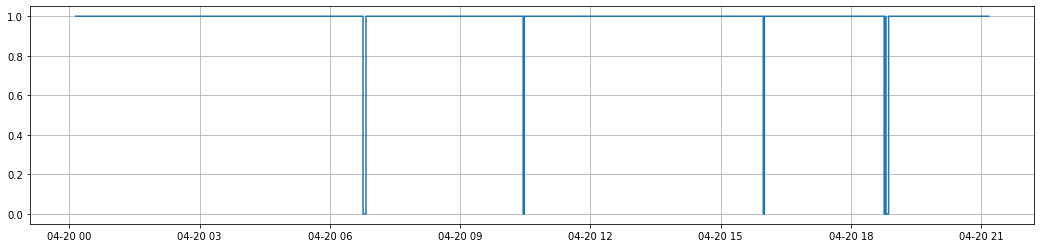

In [632]:
# reconnection time varies
# server daemon restart triggers some tegra daemons restart what increases a time while frames are not received
# average time to reconnect to all tegras ~90 seconds

half_int = 45

x = df['date'].unique()
y = np.ones(len(x))
#z_index = np.array([np.arange(i-half_int, i+half_int) for i in np.nditer(np.where(x==df_rt['date'].values))])
z_index = np.array([np.arange(i-half_int, i+half_int) for j in df_rt['date'].values for i in np.where(x==j)])
y[z_index.flatten()] = 0

plt.figure(figsize=(18, 4))
plt.ylim(-0.05, 1.05)
plt.grid()
plt.step(x, y)

**Percent of time server daemon was down**

In [633]:
total_time = (df['date'].max() - df['date'].min()).total_seconds()
down_time = 2 * half_int * df_tmp.shape[0]

(total_time - down_time) / total_time

0.9916776750330251

## Tegra daemon

**Cameras connected to server**

In [634]:
df_status['camera'].unique().tolist()

['118', '12', '2', '60001', '7']

**Available properties to analize**

In [635]:
df_status.columns.values

array(['analog_gain', 'auto_analog_gain_enabled',
       'auto_digital_gain_enabled', 'auto_exposure_enabled',
       'auto_focus_gain_limit', 'auto_ir_filter_enabled',
       'auto_model_generation_enabled',
       'auto_model_generation_interval_seconds',
       'auto_night_mode_disable_threshold',
       'auto_night_mode_enable_threshold', 'auto_night_mode_enabled',
       'auto_whitebalance', 'auto_whitebalance_interval_seconds',
       'autofocus_algorithm', 'compression_quality_modes',
       'data_routing_policy', 'day_mode_FPS', 'day_mode_denoising',
       'day_mode_saturation', 'day_mode_sharpening',
       'day_mode_whitebalance', 'denoising', 'digital_gain',
       'exposure_absolute', 'exposure_time_milliseconds', 'focus_status',
       'framerate', 'gain_absolute', 'host', 'id', 'ir_filter', 'kernel',
       'mcam_state', 'mcams_connected', 'mcams_expected', 'microcameras',
       'model', 'modelGen', 'model_generator_found', 'night_mode_FPS',
       'night_mode_denoising

**Connection stats per camera**

In [636]:
df_status = pd.concat([df_status, df_status['mcam_state'].apply(lambda row: pd.Series(row))], axis=1) #.explode('mcam_state')
df_status['mcams_lost'] = df_status['mcams_expected'] - df_status['mcams_connected']

In [645]:
df_p = pd.pivot_table(df_status[['date', 'camera', 'mcams_lost']], values='mcams_lost', index=['date'], columns=['camera'], aggfunc=np.mean)

([<matplotlib.axis.YTick at 0x7fc793b417d0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

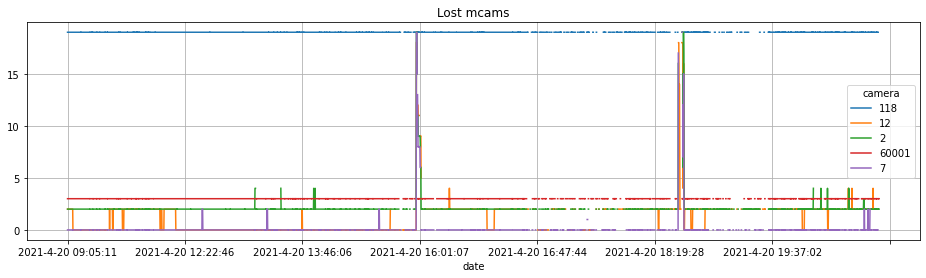

In [647]:
df_p.plot.line(title="Lost mcams", grid=True, figsize=(16, 4))
plt.yticks(np.arange(0, 20, 5))

**Plot**

In [648]:
cams = df_status['camera'].unique().tolist()
mcams = df_status['microcameras'].explode().dropna().unique().tolist()

In [649]:
df_status[mcams] = df_status[mcams].replace({"CONNECTED": 1, "NOT CONNECTED": 0})

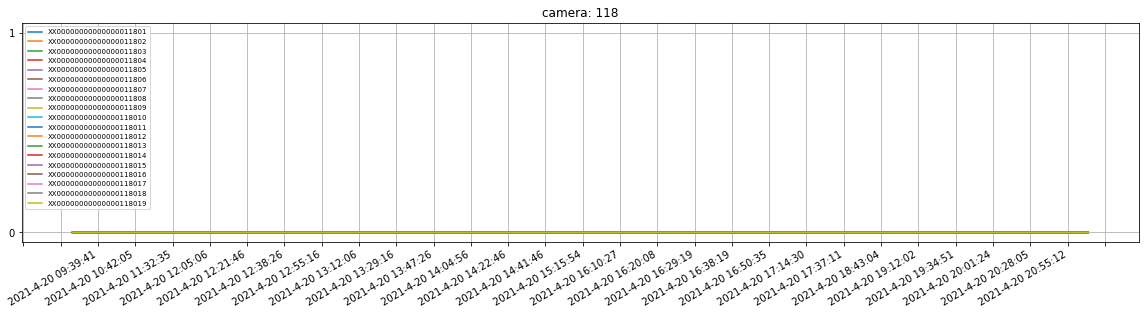

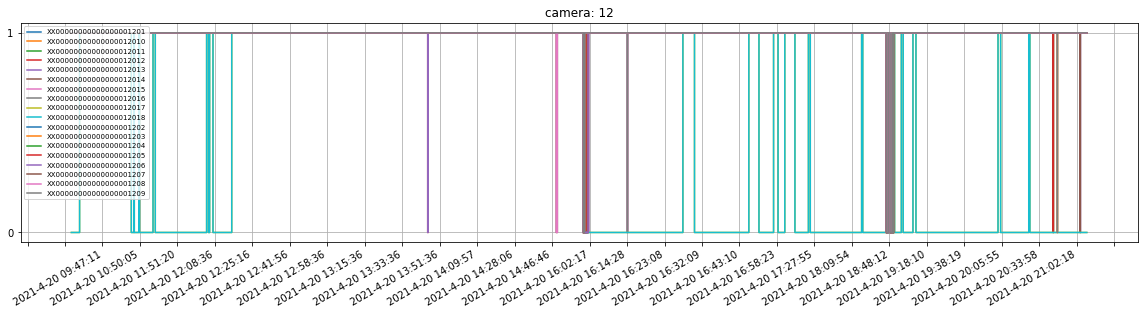

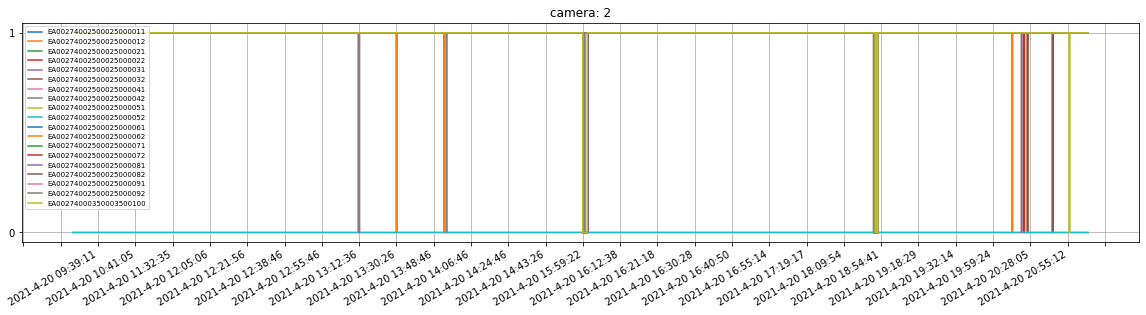

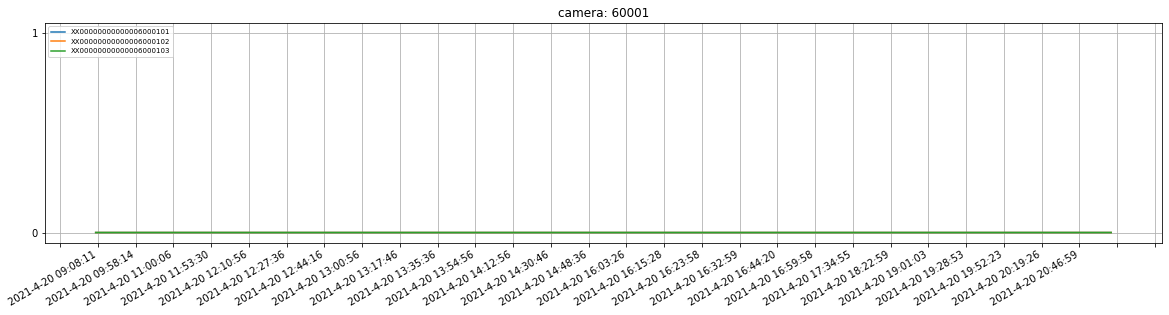

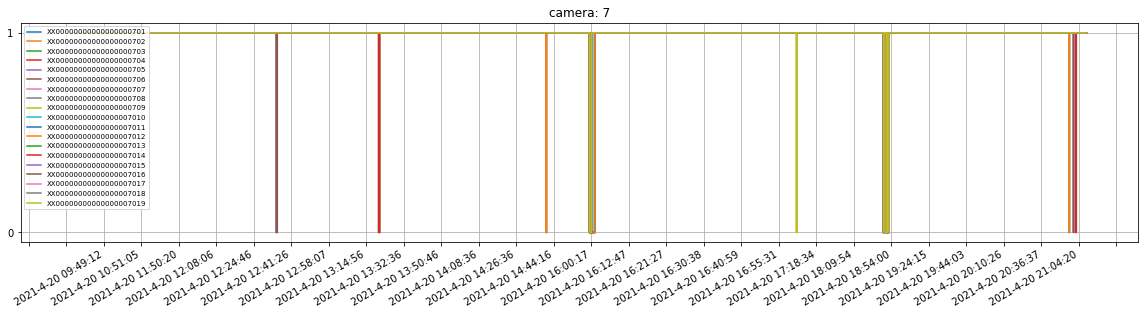

In [653]:
import matplotlib.dates as mdates

for cam in cams:
    plt.figure(figsize=(16, 4))
    plt.xticks(rotation=90)
    plt.ylim(-0.05, 1.05)
    plt.grid()
    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=2)
    plt.tight_layout()
    plt.title(f'camera: {cam}')
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    
    for mcam in df_status[df_status['camera']==cam]['microcameras'].explode().dropna().unique().tolist():
        df_tmp = df_status[df_status['camera']==cam][['date', mcam]].dropna()
        plt.step(df_tmp['date'], df_tmp[mcam].values, label=mcam)
        
    plt.legend(loc=2, prop={'size': 7})
    plt.gcf().autofmt_xdate()

**Avg tegra daemon work time per tegra**

In [651]:
df_tmp_m = df_status[['camera', 'microcameras']].explode('microcameras').dropna().groupby(['camera', 'microcameras']).count()
df_tmp_s = df_status[mcams].mean()
df_tmp_m['work_time'] = np.nan
df_tmp_m['work_time'] = df_tmp_m.apply(lambda row: df_tmp_s[row.name[-1]], axis=1)
df_tmp_m[df_tmp_m['work_time'] > 0].head(50) #only connected cameras are displayed

work_time
camera microcameras                     
12     XX00000000000000001201   0.990324
       XX00000000000000001202   0.990324
       XX00000000000000001203   0.995662
       XX00000000000000001204   0.995662
       XX00000000000000001205   0.990657
       XX00000000000000001206   0.990657
       XX00000000000000001207   0.993660
       XX00000000000000001208   0.993660
       XX00000000000000001209   0.993994
       XX00000000000000012010   0.993994
       XX00000000000000012011   0.991325
       XX00000000000000012012   0.991325
       XX00000000000000012013   0.990991
       XX00000000000000012014   0.994661
       XX00000000000000012015   0.989656
       XX00000000000000012016   0.989656
       XX00000000000000012017   0.431098
       XX00000000000000012018   0.431098
2      EA00274000350003500100   0.993364
       EA00274002500025000011   0.996350
       EA00274002500025000012   0.996350
       EA00274002500025000021   0.991705
       EA00274002500025000022   0.991705
       EA00274002500025000031   0.991374
       EA00274002500025000032   0.991374
       EA00274002500025000041   0.996682
       EA00274002500025000042   0.996682
       EA00274002500025000061   0.995687
       EA00274002500025000062   0.995687
       EA00274002500025000071   0.995355
       EA00274002500025000072   0.995355
       EA00274002500025000081   0.992701
       EA00274002500025000082   0.992701
       EA00274002500025000091   0.993364
       EA00274002500025000092   0.993364
7      XX00000000000000000701   0.996322
       XX00000000000000000702   0.996322
       XX00000000000000000703   0.992645
       XX00000000000000000704   0.992645
       XX00000000000000000705   0.995654
       XX00000000000000000706   0.995654
       XX00000000000000000707   0.992979
       XX00000000000000000708   0.992979
       XX00000000000000000709   0.993982
       XX00000000000000007010   0.993982
       XX00000000000000007011   0.991976
       XX00000000000000007012   0.991976
       XX00000000000000007013   0.995319
       XX00000000000000007014   0.995319
       XX00000000000000007015   0.995654

**Percent of time tegra daemons were down**

In [652]:
#connected cameras only

df_tmp_m[df_tmp_m['work_time'] > 0].mean()

work_time    0.972868
dtype: float64

-----------

## Render streams

In [654]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [655]:
df_s = df[df['method'].isin(['RenderStream', '~RenderStream']) & df['content'].str.contains('Constructed|Destructed', regex=True)]
df_s['is_constructed'] = df_s['content'].apply(lambda row: 'constructed' if 'Constructed' in row else 'destructed')
df_s.rename(columns={'module_id': 'stream_id'}, inplace=True)

/home/astepenko/py37-venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/astepenko/py37-venv/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [657]:
df_s_pt = pd.pivot_table(df_s, values='date', index=['stream_id'], columns=['is_constructed'], aggfunc=np.min)
df_s_pt['delta'] = df_s_pt['destructed'] - df_s_pt['constructed']
df_s_pt.tail(20)

is_constructed,constructed,destructed,delta
stream_id,,,
vFjwN6DrG,2021-04-20 17:02:52,2021-04-20 17:03:01,0 days 00:00:09
vdMML9VHp,2021-04-20 16:52:14,2021-04-20 16:52:32,0 days 00:00:18
vswRA6s0s,2021-04-20 16:51:28,2021-04-20 16:51:49,0 days 00:00:21
vxea0XuQi,2021-04-20 19:30:16,2021-04-20 19:30:36,0 days 00:00:20
w6yarPGpm,2021-04-20 16:53:40,2021-04-20 16:54:00,0 days 00:00:20
wbo0g7YdQ,2021-04-20 11:58:16,2021-04-20 15:00:19,0 days 03:02:03
weef3DlOp,2021-04-20 17:13:47,2021-04-20 17:14:04,0 days 00:00:17
x7t4pQdni,2021-04-20 19:29:14,2021-04-20 19:29:29,0 days 00:00:15
xKrGsNEjz,2021-04-20 16:58:50,2021-04-20 16:59:07,0 days 00:00:17


## Received frames

**Obtaining dataframe**

In [658]:
df_n = df[df['method'] == 'FrameRequestHandler']
df_n['content'] = df_n['content'].apply(lambda row: dict(zip(['frames_total', 'frames_succeeded', 'frames_bad', 'frames_failed', 'frames_invalid_fps'], list(map(int, re.findall(r"\d+", row))))))
df_n = pd.concat([df_n, df_n['content'].apply(pd.Series)], axis=1)
df_n.rename(columns={'module_id': 'stream_id'}, inplace=True)

/home/astepenko/py37-venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [659]:
df_n[['date', 'stream_id', 'frames_total', 'frames_succeeded', 'frames_bad', 'frames_failed', 'frames_invalid_fps']]

,date,stream_id,frames_total,frames_succeeded,frames_bad,frames_failed,frames_invalid_fps
2816804,2021-04-20 09:05:23,iF69RBHVh,5001,769,0,4232,7
2816850,2021-04-20 09:05:24,4Hf6dcjJo,5001,799,0,4202,14
2817148,2021-04-20 09:05:26,iF69RBHVh,5001,467,0,4534,0
2817233,2021-04-20 09:05:28,4Hf6dcjJo,5001,374,0,4627,0
2817237,2021-04-20 09:05:28,mV2dvOm2C,5001,915,0,4086,2
...,...,...,...,...,...,...,...
12729664,2021-04-20 21:10:04,GGIVfsVBZ,5001,4998,0,3,0
12729854,2021-04-20 21:10:06,mLMegJnBC,5001,557,0,4444,0
12731325,2021-04-20 21:10:13,20MymqiDg,5001,849,0,4152,0
12731886,2021-04-20 21:10:15,mLMegJnBC,5001,527,0,4474,0


In [660]:
df_n['frames_succeeded_rel'] = df_n['frames_succeeded'] / df_n['frames_total']
df_n['frames_bad_rel'] = df_n['frames_bad'] /df_n['frames_total']
df_n['frames_failed_rel'] = df_n['frames_failed'] / df_n['frames_total']
df_n['frames_invalid_fps_rel'] = df_n['frames_invalid_fps'] / df_n['frames_total']

**Stacked bar plot of received frames**

In [668]:
df_n_rel = df_n[['stream_id', 'frames_succeeded_rel', 'frames_bad_rel', 'frames_failed_rel', 'frames_invalid_fps_rel', 'frames_succeeded', 'frames_bad', 'frames_failed', 'frames_invalid_fps']].groupby('stream_id').mean()
df_n_rel.head(20)

,frames_succeeded_rel,frames_bad_rel,frames_failed_rel,frames_invalid_fps_rel,frames_succeeded,frames_bad,frames_failed,frames_invalid_fps
stream_id,,,,,,,,
1oNVFF8z5,0.113318,0.0,0.886682,3.615913e-07,566.701627,0.0,4434.298373,0.001808
20MymqiDg,0.417032,0.0,0.582966,2.156431e-05,2085.578431,0.0,2915.411765,0.107843
2iiRw70nR,0.043216,0.0,0.956787,4.686563e-05,216.125000,0.0,4784.890625,0.234375
32k3eKSfF,0.168366,0.0,0.831634,1.999600e-04,842.000000,0.0,4159.000000,1.000000
3kYajer3Y,0.067244,0.0,0.932756,6.343277e-02,336.287879,0.0,4664.712121,317.227273
4Hf6dcjJo,0.042904,0.0,0.957095,2.086021e-06,214.564829,0.0,4786.432936,0.010432
5rBRjYRsZ,0.153460,0.0,0.846540,1.636036e-04,767.454545,0.0,4233.545455,0.818182
74VJiYKTi,0.111560,0.0,0.888437,7.141429e-06,557.910714,0.0,4443.071429,0.035714
93eBAYy3W,0.076290,0.0,0.923710,2.104842e-05,381.526316,0.0,4619.473684,0.105263


<AxesSubplot:xlabel='stream_id'>

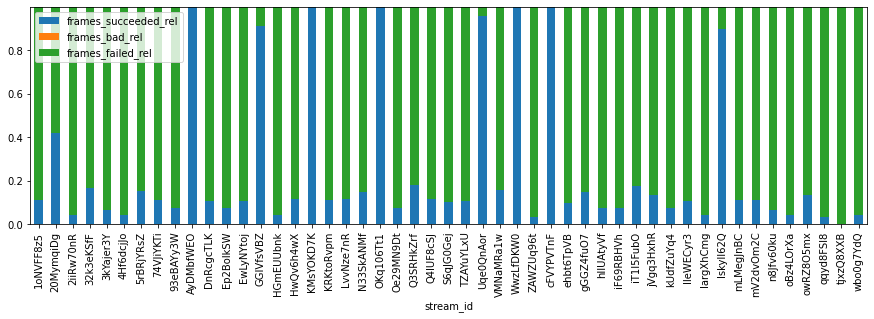

In [669]:
df_n_rel.reset_index().plot.bar(x='stream_id', y=['frames_succeeded_rel', 'frames_failed_rel'], stacked=True, figsize=(15,4))

<AxesSubplot:xlabel='stream_id'>

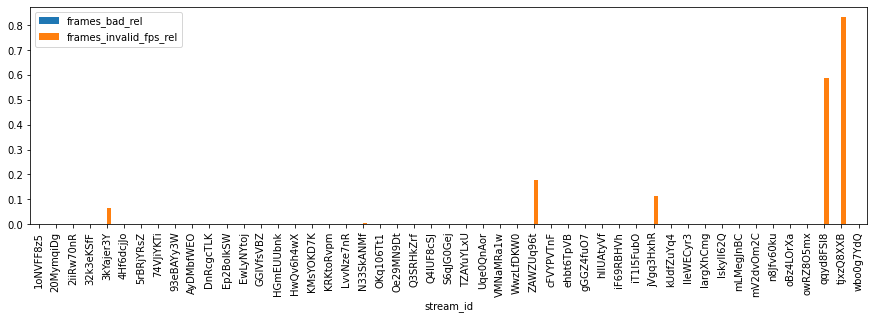

In [671]:
df_n_rel.reset_index().plot.bar(x='stream_id', y=['frames_bad_rel', 'frames_invalid_fps_rel'], figsize=(15,4))